In [357]:
import pandas as pd
import numpy as np
import operator
import os
from pathlib import Path

from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

cwd = os.getcwd() # get path of current working directory
main_folder = str(Path(cwd).parents[0]) # main folder is the lowest level in project


In [358]:
cex84_02 = pd.read_stata(main_folder + "\data\cex84_02.dta")
cex84_02 = cex84_02[cex84_02.year >= 94]
cex84_02 = cex84_02[cex84_02.year <= 97]
cex84_02['ee'] = 0
cex84_02.loc[(cex84_02['year'] <=95) & (cex84_02['educatio'] >=21), 'ee'] = 1
cex84_02.loc[(cex84_02['year'] >=96) & (cex84_02['educatio'] >=40), 'ee'] = 1
cex84_02['meanee'] = cex84_02['ee'].mean()
cex84_02

,newid,age,relation,educatio,race,sex,weeksin,emplcont,incoll,nonwork,...,cpi82,cpi_82,cpi00,cpi_00,cpi1_lag,cpi82_lag,cpi00_lag,cpi_97,ee,meanee
57681,57811,68,1,24,1,2,52,NaN,3.0,5.0,...,96.5,1.535751,172.199997,0.860627,144.500000,1.497409,0.839141,0.923364,1,0.521694
57682,57812,53,1,12,1,1,52,1.0,3.0,NaN,...,96.5,1.535751,172.199997,0.860627,144.500000,1.497409,0.839141,0.923364,0,0.521694
57683,57813,37,1,12,1,1,52,1.0,3.0,NaN,...,96.5,1.535751,172.199997,0.860627,144.500000,1.497409,0.839141,0.923364,0,0.521694
57684,57814,68,1,22,1,1,52,NaN,3.0,NaN,...,96.5,1.535751,172.199997,0.860627,144.500000,1.497409,0.839141,0.923364,1,0.521694
57685,57815,35,1,12,2,2,39,NaN,NaN,NaN,...,96.5,1.535751,172.199997,0.860627,144.500000,1.497409,0.839141,0.923364,0,0.521694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86104,92654,40,1,44,1,2,13,2.0,2.0,NaN,...,96.5,1.663212,172.199997,0.932056,156.899994,1.625907,0.911150,1.000000,1,0.521694
86106,92656,18,1,39,1,1,13,NaN,1.0,NaN,...,96.5,1.663212,172.199997,0.932056,156.899994,1.625907,0.911150,1.000000,0,0.521694
86117,92667,34,1,41,1,2,13,2.0,3.0,NaN,...,96.5,1.663212,172.199997,0.932056,156.899994,1.625907,0.911150,1.000000,1,0.521694
86135,92685,18,1,40,1,1,13,NaN,1.0,3.0,...,96.5,1.663212,172.199997,0.932056,156.899994,1.625907,0.911150,1.000000,1,0.521694


In [359]:
#Summary statistics
cex84_02[["meanee"]].describe()

,meanee
count,2.330100e+04
mean,5.216943e-01
std,1.036971e-13
min,5.216943e-01
25%,5.216943e-01
50%,5.216943e-01
75%,5.216943e-01
max,5.216943e-01


In [360]:
#Total expenditure
cex84_02['totalexp1'] = cex84_02.loc[:, 'foodhome':'charity'].sum(axis=1)
cex84_02['totalexp'] = cex84_02['totalexp1'] + cex84_02['ohint'] + cex84_02['ohtax'] + cex84_02['ohmaint']
cex84_02 = cex84_02.drop(columns=['totalexp1'])
cex84_02

,newid,age,relation,educatio,race,sex,weeksin,emplcont,incoll,nonwork,...,cpi_82,cpi00,cpi_00,cpi1_lag,cpi82_lag,cpi00_lag,cpi_97,ee,meanee,totalexp
57681,57811,68,1,24,1,2,52,NaN,3.0,5.0,...,1.535751,172.199997,0.860627,144.500000,1.497409,0.839141,0.923364,1,0.521694,19856.200012
57682,57812,53,1,12,1,1,52,1.0,3.0,NaN,...,1.535751,172.199997,0.860627,144.500000,1.497409,0.839141,0.923364,0,0.521694,20149.000000
57683,57813,37,1,12,1,1,52,1.0,3.0,NaN,...,1.535751,172.199997,0.860627,144.500000,1.497409,0.839141,0.923364,0,0.521694,47880.000000
57684,57814,68,1,22,1,1,52,NaN,3.0,NaN,...,1.535751,172.199997,0.860627,144.500000,1.497409,0.839141,0.923364,1,0.521694,38343.349976
57685,57815,35,1,12,2,2,39,NaN,NaN,NaN,...,1.535751,172.199997,0.860627,144.500000,1.497409,0.839141,0.923364,0,0.521694,4516.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86104,92654,40,1,44,1,2,13,2.0,2.0,NaN,...,1.663212,172.199997,0.932056,156.899994,1.625907,0.911150,1.000000,1,0.521694,12130.960022
86106,92656,18,1,39,1,1,13,NaN,1.0,NaN,...,1.663212,172.199997,0.932056,156.899994,1.625907,0.911150,1.000000,0,0.521694,2671.000000
86117,92667,34,1,41,1,2,13,2.0,3.0,NaN,...,1.663212,172.199997,0.932056,156.899994,1.625907,0.911150,1.000000,1,0.521694,6042.000000
86135,92685,18,1,40,1,1,13,NaN,1.0,3.0,...,1.663212,172.199997,0.932056,156.899994,1.625907,0.911150,1.000000,1,0.521694,13170.000000


In [361]:
#Expenditure used in this paper
cex84_02 = cex84_02.drop(columns=['autos'])
cex84_02['tt'] = cex84_02.loc[:, 'foodhome':'charity'].sum(axis=1)
cex84_02 = cex84_02[cex84_02.tt >= 0]
cex84_02['ltotexp'] = np.log(cex84_02['tt']) - np.log(cex84_02['cpi_97'])
cex84_02

,newid,age,relation,educatio,race,sex,weeksin,emplcont,incoll,nonwork,...,cpi_00,cpi1_lag,cpi82_lag,cpi00_lag,cpi_97,ee,meanee,totalexp,tt,ltotexp
57681,57811,68,1,24,1,2,52,NaN,3.0,5.0,...,0.860627,144.500000,1.497409,0.839141,0.923364,1,0.521694,19856.200012,18945.200012,9.929037
57682,57812,53,1,12,1,1,52,1.0,3.0,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,0,0.521694,20149.000000,17131.000000,9.828376
57683,57813,37,1,12,1,1,52,1.0,3.0,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,0,0.521694,47880.000000,40649.000000,10.692461
57684,57814,68,1,22,1,1,52,NaN,3.0,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,1,0.521694,38343.349976,34663.599976,10.533177
57685,57815,35,1,12,2,2,39,NaN,NaN,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,0,0.521694,4516.000000,4516.000000,8.495113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86104,92654,40,1,44,1,2,13,2.0,2.0,NaN,...,0.932056,156.899994,1.625907,0.911150,1.000000,1,0.521694,12130.960022,9609.960022,9.170555
86106,92656,18,1,39,1,1,13,NaN,1.0,NaN,...,0.932056,156.899994,1.625907,0.911150,1.000000,0,0.521694,2671.000000,2671.000000,7.890208
86117,92667,34,1,41,1,2,13,2.0,3.0,NaN,...,0.932056,156.899994,1.625907,0.911150,1.000000,1,0.521694,6042.000000,4092.000000,8.316789
86135,92685,18,1,40,1,1,13,NaN,1.0,3.0,...,0.932056,156.899994,1.625907,0.911150,1.000000,1,0.521694,13170.000000,1170.000000,7.064759


,newid,age,relation,educatio,race,sex,weeksin,emplcont,incoll,nonwork,...,cpi_00,cpi1_lag,cpi82_lag,cpi00_lag,cpi_97,ee,meanee,totalexp,tt,ltotexp
0,57811,68,1,24,1,2,52,NaN,3.0,5.0,...,0.860627,144.500000,1.497409,0.839141,0.923364,1.0,0.521694,19856.199219,18945.199219,9.929037
1,57812,53,1,12,1,1,52,1.0,3.0,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,0.0,0.521694,20149.000000,17131.000000,9.828376
2,57813,37,1,12,1,1,52,1.0,3.0,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,0.0,0.521694,47880.000000,40649.000000,10.692461
3,57814,68,1,22,1,1,52,NaN,3.0,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,1.0,0.521694,38343.351562,34663.601562,10.533176
4,57815,35,1,12,2,2,39,NaN,NaN,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,0.0,0.521694,4516.000000,4516.000000,8.495113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23293,92654,40,1,44,1,2,13,2.0,2.0,NaN,...,0.932056,156.899994,1.625907,0.911150,1.000000,1.0,0.521694,12130.959961,9609.959961,9.170555
23294,92656,18,1,39,1,1,13,NaN,1.0,NaN,...,0.932056,156.899994,1.625907,0.911150,1.000000,0.0,0.521694,2671.000000,2671.000000,7.890208
23295,92667,34,1,41,1,2,13,2.0,3.0,NaN,...,0.932056,156.899994,1.625907,0.911150,1.000000,1.0,0.521694,6042.000000,4092.000000,8.316789
23296,92685,18,1,40,1,1,13,NaN,1.0,3.0,...,0.932056,156.899994,1.625907,0.911150,1.000000,1.0,0.521694,13170.000000,1170.000000,7.064759


In [363]:
#Aggregate some small expenses with similar expenses
cex84_02_div['foodout'] = cex84_02_div['foodout'] + cex84_02_div['foodwork'] 
cex84_02_div['renthome'] = cex84_02_div['renthome'] + cex84_02_div['rentothr']
cex84_02_div['pubs'] = cex84_02_div['pubs'] + cex84_02_div['books']
cex84_02_div['hospital'] = cex84_02_div['hospital'] + cex84_02_div['nurshome']
cex84_02_div['masstran'] = cex84_02_div['masstran'] + cex84_02_div['tolls']
cex84_02_div = cex84_02_div.drop(columns=['foodwork', 'rentothr', 'books', 'nurshome', 'tolls'])
cex84_02_div

,newid,age,relation,educatio,race,sex,weeksin,emplcont,incoll,nonwork,...,cpi_00,cpi1_lag,cpi82_lag,cpi00_lag,cpi_97,ee,meanee,totalexp,tt,ltotexp
0,57811,68,1,24,1,2,52,NaN,3.0,5.0,...,0.860627,144.500000,1.497409,0.839141,0.923364,1.0,0.521694,19856.199219,18945.199219,9.929037
1,57812,53,1,12,1,1,52,1.0,3.0,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,0.0,0.521694,20149.000000,17131.000000,9.828376
2,57813,37,1,12,1,1,52,1.0,3.0,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,0.0,0.521694,47880.000000,40649.000000,10.692461
3,57814,68,1,22,1,1,52,NaN,3.0,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,1.0,0.521694,38343.351562,34663.601562,10.533176
4,57815,35,1,12,2,2,39,NaN,NaN,NaN,...,0.860627,144.500000,1.497409,0.839141,0.923364,0.0,0.521694,4516.000000,4516.000000,8.495113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23293,92654,40,1,44,1,2,13,2.0,2.0,NaN,...,0.932056,156.899994,1.625907,0.911150,1.000000,1.0,0.521694,12130.959961,9609.959961,9.170555
23294,92656,18,1,39,1,1,13,NaN,1.0,NaN,...,0.932056,156.899994,1.625907,0.911150,1.000000,0.0,0.521694,2671.000000,2671.000000,7.890208
23295,92667,34,1,41,1,2,13,2.0,3.0,NaN,...,0.932056,156.899994,1.625907,0.911150,1.000000,1.0,0.521694,6042.000000,4092.000000,8.316789
23296,92685,18,1,40,1,1,13,NaN,1.0,3.0,...,0.932056,156.899994,1.625907,0.911150,1.000000,1.0,0.521694,13170.000000,1170.000000,7.064759


In [364]:
cex84_02_div['single'] = 1
cex84_02.loc[cex84_02['wife_ed'] >=1, 'single'] = 0 
cex84_02_div['wifeH'] = 0
cex84_02_div.loc[cex84_02_div['wife_ed'] >=2, 'wifeH'] = 1 #/*spouse with some college, wife_ed with college ==3*/

In [365]:
#Table descriptive
cex84_02_div['exptot97'] = np.log(cex84_02_div['totalexp']/cex84_02_div['cpi_97'])
cex84_02_div['expnondur97'] = np.log(cex84_02_div['tt']/cex84_02_div['cpi_97'])
cex84_02_div['wages97'] = np.log(cex84_02_div['income']/cex84_02_div['cpi_97'])
cex84_02_div['sex'] = cex84_02_div['sex'] - 1
cex84_02_div

C:\Users\gimat\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gimat\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,newid,age,relation,educatio,race,sex,weeksin,emplcont,incoll,nonwork,...,ee,meanee,totalexp,tt,ltotexp,single,wifeH,exptot97,expnondur97,wages97
0,57811,68,1,24,1,1,52,NaN,3.0,5.0,...,1.0,0.521694,19856.199219,18945.199219,9.929037,1,0,9.976003,9.929037,9.398836
1,57812,53,1,12,1,0,52,1.0,3.0,NaN,...,0.0,0.521694,20149.000000,17131.000000,9.828376,1,1,9.990642,9.828376,-inf
2,57813,37,1,12,1,0,52,1.0,3.0,NaN,...,0.0,0.521694,47880.000000,40649.000000,10.692461,1,1,10.856184,10.692461,-inf
3,57814,68,1,22,1,0,52,NaN,3.0,NaN,...,1.0,0.521694,38343.351562,34663.601562,10.533176,1,1,10.634068,10.533176,10.518718
4,57815,35,1,12,2,1,39,NaN,NaN,NaN,...,0.0,0.521694,4516.000000,4516.000000,8.495113,1,0,8.495113,8.495113,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23293,92654,40,1,44,1,1,13,2.0,2.0,NaN,...,1.0,0.521694,12130.959961,9609.959961,9.170555,1,0,9.403516,9.170555,10.900621
23294,92656,18,1,39,1,0,13,NaN,1.0,NaN,...,0.0,0.521694,2671.000000,2671.000000,7.890208,1,0,7.890208,7.890208,-inf
23295,92667,34,1,41,1,1,13,2.0,3.0,NaN,...,1.0,0.521694,6042.000000,4092.000000,8.316789,1,0,8.706491,8.316789,10.679711
23296,92685,18,1,40,1,0,13,NaN,1.0,3.0,...,1.0,0.521694,13170.000000,1170.000000,7.064759,1,0,9.485697,7.064759,-inf


In [237]:
cex84_02_div.rename(columns={'foodhome':'share_1', 'foodout':'share_2', 'tobacco':'share_3', 'alcohol':'share_4', 'niteclub':'share_5', 'clothes':'share_6','tailors':'share_7', 'jewelry':'share_8', 'hlthbeau':'share_9', 'renthome':'share_10', 'furnish':'share_11', 'elect':'share_12', 'gas':'share_13','water':'share_14', 'homefuel':'share_15','telephon':'share_16', 'servants':'share_17', 'drugs':'share_18', 'orthopd':'share_19', 'doctors':'share_20', 'hospital':'share_21', 'helthins':'share_22', 'busiserv':'share_23', 'lifeins':'share_24', 'parts':'share_25','carservs':'share_26', 'gasoline':'share_27', 'autoins':'share_28', 'masstran':'share_29', 'othtrans':'share_30', 'airfare':'share_31', 'pubs':'share_32', 'recsport':'share_33', 'othrec':'share_34', 'highedu':'share_35','lowedu':'share_36', 'othedu':'share_37', 'charity':'share_38'}, inplace=True)
cex84_02_div

,newid,age,relation,educatio,race,sex,weeksin,emplcont,incoll,nonwork,...,ee,meanee,totalexp,tt,ltotexp,single,wifeH,exptot97,expnondur97,wages97
0,57811,68,1,24,1,1,52,NaN,3.0,5.0,...,1.0,0.521694,19856.199219,18945.199219,9.929037,1,0,9.976003,9.929037,9.398836
1,57812,53,1,12,1,0,52,1.0,3.0,NaN,...,0.0,0.521694,20149.000000,17131.000000,9.828376,1,1,9.990642,9.828376,-inf
2,57813,37,1,12,1,0,52,1.0,3.0,NaN,...,0.0,0.521694,47880.000000,40649.000000,10.692461,1,1,10.856184,10.692461,-inf
3,57814,68,1,22,1,0,52,NaN,3.0,NaN,...,1.0,0.521694,38343.351562,34663.601562,10.533176,1,1,10.634068,10.533176,10.518718
4,57815,35,1,12,2,1,39,NaN,NaN,NaN,...,0.0,0.521694,4516.000000,4516.000000,8.495113,1,0,8.495113,8.495113,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23293,92654,40,1,44,1,1,13,2.0,2.0,NaN,...,1.0,0.521694,12130.959961,9609.959961,9.170555,1,0,9.403516,9.170555,10.900621
23294,92656,18,1,39,1,0,13,NaN,1.0,NaN,...,0.0,0.521694,2671.000000,2671.000000,7.890208,1,0,7.890208,7.890208,-inf
23295,92667,34,1,41,1,1,13,2.0,3.0,NaN,...,1.0,0.521694,6042.000000,4092.000000,8.316789,1,0,8.706491,8.316789,10.679711
23296,92685,18,1,40,1,0,13,NaN,1.0,3.0,...,1.0,0.521694,13170.000000,1170.000000,7.064759,1,0,9.485697,7.064759,-inf


In [238]:
filter_col = [col for col in cex84_02_div if col.startswith('share')]
filter_col

['share_1',
 'share_2',
 'share_3',
 'share_4',
 'share_5',
 'share_6',
 'share_7',
 'share_8',
 'share_9',
 'share_10',
 'share_11',
 'share_12',
 'share_13',
 'share_14',
 'share_15',
 'share_16',
 'share_17',
 'share_18',
 'share_19',
 'share_20',
 'share_21',
 'share_22',
 'share_23',
 'share_24',
 'share_25',
 'share_26',
 'share_27',
 'share_28',
 'share_29',
 'share_30',
 'share_31',
 'share_32',
 'share_33',
 'share_34',
 'share_35',
 'share_36',
 'share_37',
 'share_38']

In [239]:
cex84_02_div = cex84_02_div[['share_1',
 'share_2',
 'share_3',
 'share_4',
 'share_5',
 'share_6',
 'share_7',
 'share_8',
 'share_9',
 'share_10',
 'share_11',
 'share_12',
 'share_13',
 'share_14',
 'share_15',
 'share_16',
 'share_17',
 'share_18',
 'share_19',
 'share_20',
 'share_21',
 'share_22',
 'share_23',
 'share_24',
 'share_25',
 'share_26',
 'share_27',
 'share_28',
 'share_29',
 'share_30',
 'share_31',
 'share_32',
 'share_33',
 'share_34',
 'share_35',
 'share_36',
 'share_37',
 'share_38','year', 'ltotexp', 'age', 'ee', 'sex', 'nchild', 'meanee']]


In [240]:
cex84_02_div

,share_1,share_2,share_3,share_4,share_5,share_6,share_7,share_8,share_9,share_10,...,share_37,share_38,year,ltotexp,age,ee,sex,nchild,year,meanee
0,0.170861,0.038004,0.000000,0.023278,0.007284,0.015043,0.007231,0.000000,0.058273,0.007073,...,0.000000,0.015835,94.0,9.929037,68,1.0,1,0.0,94.0,0.521694
1,0.248088,0.122526,0.000000,0.000000,0.000992,0.034207,0.003211,0.000000,0.019964,0.007997,...,0.000000,0.001167,94.0,9.828376,53,0.0,0,1.0,94.0,0.521694
2,0.140372,0.086005,0.000000,0.016015,0.005904,0.063200,0.004920,0.001722,0.009963,0.022141,...,0.001107,0.000000,94.0,10.692461,37,0.0,0,2.0,94.0,0.521694
3,0.128665,0.070391,0.024002,0.000000,0.001731,0.132733,0.005885,0.006174,0.020079,0.001875,...,0.008655,0.063467,94.0,10.533176,68,1.0,0,0.0,94.0,0.521694
4,0.437555,0.026572,0.000000,0.003322,0.000000,0.032551,0.015500,0.000000,0.038530,0.070416,...,0.000000,0.000000,94.0,8.495113,35,0.0,1,1.0,94.0,0.521694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23293,0.088970,0.045266,0.000000,0.004683,0.003122,0.096775,0.053070,0.031218,0.006244,0.000000,...,0.013007,0.078564,97.0,9.170555,40,1.0,1,0.0,97.0,0.521694
23294,0.048671,0.172220,0.000000,0.000000,0.000000,0.088731,0.000000,0.000000,0.007862,0.219019,...,0.000000,0.000000,97.0,7.890208,18,0.0,0,0.0,97.0,0.521694
23295,0.190616,0.130010,0.095308,0.036657,0.014174,0.010020,0.000000,0.000000,0.008798,0.205279,...,0.000489,0.000000,97.0,8.316789,34,1.0,1,1.0,97.0,0.521694
23296,0.333333,0.401709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,...,0.000000,0.000000,97.0,7.064759,18,1.0,0,0.0,97.0,0.521694


In [241]:
cex84_02_div['id'] = np.arange(1, len(cex84_02_div)+1)
cex84_02_div

<ipython-input-241-714d7b4112dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cex84_02_div['id'] = np.arange(1, len(cex84_02_div)+1)


,share_1,share_2,share_3,share_4,share_5,share_6,share_7,share_8,share_9,share_10,...,share_38,year,ltotexp,age,ee,sex,nchild,year,meanee,id
0,0.170861,0.038004,0.000000,0.023278,0.007284,0.015043,0.007231,0.000000,0.058273,0.007073,...,0.015835,94.0,9.929037,68,1.0,1,0.0,94.0,0.521694,1
1,0.248088,0.122526,0.000000,0.000000,0.000992,0.034207,0.003211,0.000000,0.019964,0.007997,...,0.001167,94.0,9.828376,53,0.0,0,1.0,94.0,0.521694,2
2,0.140372,0.086005,0.000000,0.016015,0.005904,0.063200,0.004920,0.001722,0.009963,0.022141,...,0.000000,94.0,10.692461,37,0.0,0,2.0,94.0,0.521694,3
3,0.128665,0.070391,0.024002,0.000000,0.001731,0.132733,0.005885,0.006174,0.020079,0.001875,...,0.063467,94.0,10.533176,68,1.0,0,0.0,94.0,0.521694,4
4,0.437555,0.026572,0.000000,0.003322,0.000000,0.032551,0.015500,0.000000,0.038530,0.070416,...,0.000000,94.0,8.495113,35,0.0,1,1.0,94.0,0.521694,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23293,0.088970,0.045266,0.000000,0.004683,0.003122,0.096775,0.053070,0.031218,0.006244,0.000000,...,0.078564,97.0,9.170555,40,1.0,1,0.0,97.0,0.521694,23294
23294,0.048671,0.172220,0.000000,0.000000,0.000000,0.088731,0.000000,0.000000,0.007862,0.219019,...,0.000000,97.0,7.890208,18,0.0,0,0.0,97.0,0.521694,23295
23295,0.190616,0.130010,0.095308,0.036657,0.014174,0.010020,0.000000,0.000000,0.008798,0.205279,...,0.000000,97.0,8.316789,34,1.0,1,1.0,97.0,0.521694,23296
23296,0.333333,0.401709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,...,0.000000,97.0,7.064759,18,1.0,0,0.0,97.0,0.521694,23297


In [242]:
#wide to long 
wide_to_long = pd.read_stata('wide_to_long.dta')
wide_to_long

,id,ind,age,sex,nchild,share,year,ee,meanee,ltotexp
0,1.0,1,68,1,0.0,0.170861,94.0,1.0,0.521694,9.929037
1,1.0,2,68,1,0.0,0.038004,94.0,1.0,0.521694,9.929037
2,1.0,3,68,1,0.0,0.000000,94.0,1.0,0.521694,9.929037
3,1.0,4,68,1,0.0,0.023278,94.0,1.0,0.521694,9.929037
4,1.0,5,68,1,0.0,0.007284,94.0,1.0,0.521694,9.929037
...,...,...,...,...,...,...,...,...,...,...
885319,23298.0,34,28,0,0.0,0.009594,97.0,1.0,0.521694,8.047830
885320,23298.0,35,28,0,0.0,0.000000,97.0,1.0,0.521694,8.047830
885321,23298.0,36,28,0,0.0,0.000000,97.0,1.0,0.521694,8.047830
885322,23298.0,37,28,0,0.0,0.000000,97.0,1.0,0.521694,8.047830


In [243]:
wl1 = wide_to_long.groupby('ind')['share', 'meanee'].mean()
wl2 = wide_to_long.groupby('ind')['share'].agg(['std'])
wl3 = pd.merge(wl1, wl2, on='ind').rename(columns={'std': 'sigmash'})
wl3['sigmash'] = wl3['sigmash']**2
wl3 

<ipython-input-243-0b9079d73d9c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  wl1 = wide_to_long.groupby('ind')['share', 'meanee'].mean()


,share,meanee,sigmash
ind,,,
1,0.182473,0.521694,0.010237
2,0.055977,0.521694,0.002969
3,0.014688,0.521694,0.000890
4,0.007091,0.521694,0.000247
5,0.006383,0.521694,0.000279
6,0.047360,0.521694,0.002110
7,0.006510,0.521694,0.000111
8,0.004512,0.521694,0.000330
9,0.013001,0.521694,0.000226


In [244]:
wl3.to_stata('shares')

In [245]:
dummies = pd.get_dummies(wide_to_long['ind'])
wide_to_long_w_dummies = pd.concat([wide_to_long, dummies], axis=1)
wide_to_long_w_dummies

,id,ind,age,sex,nchild,share,year,ee,meanee,ltotexp,...,29,30,31,32,33,34,35,36,37,38
0,1.0,1,68,1,0.0,0.170861,94.0,1.0,0.521694,9.929037,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,68,1,0.0,0.038004,94.0,1.0,0.521694,9.929037,...,0,0,0,0,0,0,0,0,0,0
2,1.0,3,68,1,0.0,0.000000,94.0,1.0,0.521694,9.929037,...,0,0,0,0,0,0,0,0,0,0
3,1.0,4,68,1,0.0,0.023278,94.0,1.0,0.521694,9.929037,...,0,0,0,0,0,0,0,0,0,0
4,1.0,5,68,1,0.0,0.007284,94.0,1.0,0.521694,9.929037,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885319,23298.0,34,28,0,0.0,0.009594,97.0,1.0,0.521694,8.047830,...,0,0,0,0,0,1,0,0,0,0
885320,23298.0,35,28,0,0.0,0.000000,97.0,1.0,0.521694,8.047830,...,0,0,0,0,0,0,1,0,0,0
885321,23298.0,36,28,0,0.0,0.000000,97.0,1.0,0.521694,8.047830,...,0,0,0,0,0,0,0,1,0,0
885322,23298.0,37,28,0,0.0,0.000000,97.0,1.0,0.521694,8.047830,...,0,0,0,0,0,0,0,0,1,0


In [246]:
#Unable to allocate 5.70 TiB for an array with shape (885286, 885324) and data type float64
# ltotexp_dum = dummies*wide_to_long['ltotexp']

In [247]:
shares_reg = pd.read_stata('shares_reg.dta')
shares_reg

,bdum1,bdum2,bdum3,bdum4,bdum5,bdum6,bdum7,bdum8,bdum9,bdum10,...,sgdum29,sgdum30,sgdum31,sgdum32,sgdum33,sgdum34,sgdum35,sgdum36,sgdum37,sgdum38
0,-0.047423,0.005126,-0.004169,-0.00036,0.000893,0.005473,-0.000607,0.002969,-0.000347,-0.027901,...,0.000171,0.000148,0.000299,0.000366,0.000635,0.000501,0.000659,0.000424,0.000177,0.000548


In [248]:
shares_reg['id'] = np.arange(1, len(shares_reg)+1)

In [249]:
shares_reg_long = pd.wide_to_long(shares_reg,["bdum", "gdum", "sbdum", "sgdum"], i='id', j="ind")

In [250]:
shares = pd.read_stata('shares')
shares_joint = pd.merge(shares_reg_long, shares, on='ind')
shares_joint.rename(columns={'bdum':'incomebeta', 'gdum':'educbeta', 'share':'meansh'}, inplace=True)
shares_joint['sigmaincome'] = shares_joint['sbdum'] 
shares_joint['sigmaedu'] = shares_joint['sgdum'] 
shares_joint

,ind,incomebeta,educbeta,sbdum,sgdum,meansh,meanee,sigmash,sigmaincome,sigmaedu
0,1,-0.047423,-0.051537,0.000966,0.001285,0.182473,0.521694,0.010237,0.000966,0.001285
1,2,0.005126,0.012999,0.000608,0.000705,0.055977,0.521694,0.002969,0.000608,0.000705
2,3,-0.004169,-0.011690,0.000331,0.000426,0.014688,0.521694,0.000890,0.000331,0.000426
3,4,-0.000360,0.000020,0.000176,0.000212,0.007091,0.521694,0.000247,0.000176,0.000212
4,5,0.000893,0.001827,0.000148,0.000213,0.006383,0.521694,0.000279,0.000148,0.000213
5,6,0.005473,0.006713,0.000496,0.000609,0.047360,0.521694,0.002110,0.000496,0.000609
6,7,-0.000607,0.000297,0.000116,0.000141,0.006510,0.521694,0.000111,0.000116,0.000141
7,8,0.002969,0.001802,0.000159,0.000241,0.004512,0.521694,0.000330,0.000159,0.000241
8,9,-0.000347,0.001019,0.000238,0.000201,0.013001,0.521694,0.000226,0.000238,0.000201
9,10,-0.027901,-0.024712,0.001399,0.002096,0.130707,0.521694,0.026813,0.001399,0.002096


In [251]:
shares_joint['elastincome'] = (shares_joint['incomebeta']/shares_joint['meansh'])+1
shares_joint['sigmaincome']  = shares_joint['sigmaincome'] **2/shares_joint['meansh'] **2
shares_joint['sigmaincome']  = shares_joint['sigmaincome'] **(1/2)

shares_joint['elastedu'] = (shares_joint['educbeta']*shares_joint['meanee'])/shares_joint['meansh']
shares_joint['sigmaedu']  = shares_joint['sigmaedu'] **2*(shares_joint['meanee']/shares_joint['meansh'])**2
shares_joint['sigmaedu']  = shares_joint['sigmaedu'] **(1/2)

shares_joint

,ind,incomebeta,educbeta,sbdum,sgdum,meansh,meanee,sigmash,sigmaincome,sigmaedu,elastincome,elastedu
0,1,-0.047423,-0.051537,0.000966,0.001285,0.182473,0.521694,0.010237,0.005294,0.003674,0.740111,-0.147344
1,2,0.005126,0.012999,0.000608,0.000705,0.055977,0.521694,0.002969,0.010854,0.006566,1.091576,0.121152
2,3,-0.004169,-0.011690,0.000331,0.000426,0.014688,0.521694,0.000890,0.022542,0.015119,0.716143,-0.415191
3,4,-0.000360,0.000020,0.000176,0.000212,0.007091,0.521694,0.000247,0.024871,0.015566,0.949225,0.001460
4,5,0.000893,0.001827,0.000148,0.000213,0.006383,0.521694,0.000279,0.023225,0.017431,1.139962,0.149348
5,6,0.005473,0.006713,0.000496,0.000609,0.047360,0.521694,0.002110,0.010483,0.006714,1.115562,0.073944
6,7,-0.000607,0.000297,0.000116,0.000141,0.006510,0.521694,0.000111,0.017796,0.011293,0.906697,0.023766
7,8,0.002969,0.001802,0.000159,0.000241,0.004512,0.521694,0.000330,0.035263,0.027911,1.658046,0.208344
8,9,-0.000347,0.001019,0.000238,0.000201,0.013001,0.521694,0.000226,0.018301,0.008066,0.973281,0.040888
9,10,-0.027901,-0.024712,0.001399,0.002096,0.130707,0.521694,0.026813,0.010702,0.008364,0.786536,-0.098634


In [252]:
shares_joint.to_stata('elast')

In [253]:
'''
skillintUS 
skillintUS = pd.read_stata('skillintUS')
shares_joint = pd.merge(shares_joint, skillintUS, on='ind')
shares_joint
'''

"\nskillintUS \nskillintUS = pd.read_stata('skillintUS')\nshares_joint = pd.merge(shares_joint, skillintUS, on='ind')\nshares_joint\n"

In [254]:
shares_joint_ratio = pd.read_stata('shares_joint_ratio.dta')
shares_joint_ratio

,id,ind,incomebeta,sbdum,educbeta,sgdum,meansh,meanee,sigmash,sigmaincome,sigmaedu,elastincome,elastedu,ratio80
0,1.0,1.0,-0.047423,0.000966,-0.051537,0.001285,0.182473,0.521694,0.010237,0.005294,0.003674,0.740111,-0.147344,0.236263
1,1.0,2.0,0.005126,0.000608,0.012999,0.000705,0.055977,0.521694,0.002969,0.010854,0.006566,1.091576,0.121152,0.265507
2,1.0,3.0,-0.004169,0.000331,-0.011690,0.000426,0.014688,0.521694,0.000890,0.022542,0.015119,0.716143,-0.415191,0.254717
3,1.0,4.0,-0.000360,0.000176,0.000020,0.000212,0.007091,0.521694,0.000247,0.024871,0.015566,0.949225,0.001460,0.338983
4,1.0,5.0,0.000893,0.000148,0.001827,0.000213,0.006383,0.521694,0.000279,0.023225,0.017431,1.139961,0.149348,NaN
5,1.0,6.0,0.005473,0.000496,0.006713,0.000609,0.047360,0.521694,0.002110,0.010483,0.006714,1.115562,0.073944,0.135813
6,1.0,7.0,-0.000607,0.000116,0.000297,0.000141,0.006510,0.521694,0.000111,0.017796,0.011293,0.906697,0.023766,NaN
7,1.0,8.0,0.002969,0.000159,0.001802,0.000241,0.004512,0.521694,0.000330,0.035263,0.027911,1.658046,0.208344,0.241667
8,1.0,9.0,-0.000347,0.000238,0.001019,0.000201,0.013001,0.521694,0.000226,0.018301,0.008066,0.973281,0.040888,0.273007
9,1.0,10.0,-0.027901,0.001399,-0.024712,0.002096,0.130707,0.521694,0.026813,0.010702,0.008364,0.786536,-0.098634,0.282216


In [255]:
#***some industries match to multiple goods
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 7, 'ratio80'] = 0.2395 #/*repairs*/
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 24, 'ratio80'] = 0.531 #/*insurance*/
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 28, 'ratio80'] = 0.531  #/*repairs*/
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 5, 'ratio80'] = 0.265 #/*eating and drinking places*/
shares_joint_ratio = shares_joint_ratio[['ind', 'elastedu', 'elastincome', 'ratio80', 'educbeta', 'incomebeta', 'sigmaedu', 'sigmaincome', 'meansh', 'sgdum']]
shares_joint_ratio

,ind,elastedu,elastincome,ratio80,educbeta,incomebeta,sigmaedu,sigmaincome,meansh,sgdum
0,1.0,-0.147344,0.740111,0.236263,-0.051537,-0.047423,0.003674,0.005294,0.182473,0.001285
1,2.0,0.121152,1.091576,0.265507,0.012999,0.005126,0.006566,0.010854,0.055977,0.000705
2,3.0,-0.415191,0.716143,0.254717,-0.011690,-0.004169,0.015119,0.022542,0.014688,0.000426
3,4.0,0.001460,0.949225,0.338983,0.000020,-0.000360,0.015566,0.024871,0.007091,0.000212
4,5.0,0.149348,1.139961,0.265000,0.001827,0.000893,0.017431,0.023225,0.006383,0.000213
5,6.0,0.073944,1.115562,0.135813,0.006713,0.005473,0.006714,0.010483,0.047360,0.000609
6,7.0,0.023766,0.906697,0.239500,0.000297,-0.000607,0.011293,0.017796,0.006510,0.000141
7,8.0,0.208344,1.658046,0.241667,0.001802,0.002969,0.027911,0.035263,0.004512,0.000241
8,9.0,0.040888,0.973281,0.273007,0.001019,-0.000347,0.008066,0.018301,0.013001,0.000201
9,10.0,-0.098634,0.786536,0.282216,-0.024712,-0.027901,0.008364,0.010702,0.130707,0.002096


In [256]:
#SAVE ELASTICITIES FOR IPUM DATA
shares_joint_ratio.to_stata('elast_IPUM')

In [353]:
#*TABLE 1 ELASTICITIES
elasticities = shares_joint_ratio.groupby('ind')['educbeta', 'elastedu', 'incomebeta', 'elastincome', 'ratio80'].mean()
TABLE1= elasticities.rename(columns={'educbeta': "Education coefficient", 'elastedu':'Education elastisity','incomebeta':"Income coefficient", 'elastincome':"Income elasticity", 'ratio80':'Skill intensity' })
TABLE1 

<ipython-input-353-0b73eb6e6035>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  elasticities = shares_joint_ratio.groupby('ind')['educbeta', 'elastedu', 'incomebeta', 'elastincome', 'ratio80'].mean()


,Education coefficient,Education elastisity,Income coefficient,Income elasticity,Skill intensity
ind,,,,,
1.0,-0.051537,-0.147344,-0.047423,0.740111,0.236263
2.0,0.012999,0.121152,0.005126,1.091576,0.265507
3.0,-0.011690,-0.415191,-0.004169,0.716143,0.254717
4.0,0.000020,0.001460,-0.000360,0.949225,0.338983
5.0,0.001827,0.149348,0.000893,1.139961,0.265000
6.0,0.006713,0.073944,0.005473,1.115562,0.135813
7.0,0.000297,0.023766,-0.000607,0.906697,0.239500
8.0,0.001802,0.208344,0.002969,1.658046,0.241667
9.0,0.001019,0.040888,-0.000347,0.973281,0.273007


In [260]:
#Correlation
df = pd.DataFrame(elasticities,columns=['elastedu', 'elastincome'])
corrMatrix = df.corr()
corrMatrix

,elastedu,elastincome
elastedu,1.000000,0.781518
elastincome,0.781518,1.000000


In [354]:
## FIGURE 1 PLOT
shares_joint_ratio['ratio802'] = shares_joint_ratio['ratio80'] **2
shares_joint_ratio

,ind,elastedu,elastincome,ratio80,educbeta,incomebeta,sigmaedu,sigmaincome,meansh,sgdum,ratio802,hat,hat1,sic
0,1.0,-0.147344,0.740111,0.236263,-0.051537,-0.047423,0.003674,0.005294,0.182473,0.001285,0.055820,-0.033839,-0.025373,17.0
1,2.0,0.121152,1.091576,0.265507,0.012999,0.005126,0.006566,0.010854,0.055977,0.000705,0.070494,-0.024423,-0.039433,121.0
2,3.0,-0.415191,0.716143,0.254717,-0.011690,-0.004169,0.015119,0.022542,0.014688,0.000426,0.064881,-0.027897,-0.034771,19.0
3,4.0,0.001460,0.949225,0.338983,0.000020,-0.000360,0.015566,0.024871,0.007091,0.000212,0.114910,-0.000763,-0.054828,18.0
4,5.0,0.149348,1.139961,0.265000,0.001827,0.000893,0.017431,0.023225,0.006383,0.000213,0.070225,-0.024586,-0.039228,121.0
5,6.0,0.073944,1.115562,0.135813,0.006713,0.005473,0.006714,0.010483,0.047360,0.000609,0.018445,-0.066185,0.057321,22.0
6,7.0,0.023766,0.906697,0.239500,0.000297,-0.000607,0.011293,0.017796,0.006510,0.000141,0.057360,-0.032797,-0.027152,124.0
7,8.0,0.208344,1.658046,0.241667,0.001802,0.002969,0.027911,0.035263,0.004512,0.000241,0.058403,-0.032099,-0.028312,45.0
8,9.0,0.040888,0.973281,0.273007,0.001019,-0.000347,0.008066,0.018301,0.013001,0.000201,0.074533,-0.022008,-0.042311,124.0
9,10.0,-0.098634,0.786536,0.282216,-0.024712,-0.027901,0.008364,0.010702,0.130707,0.002096,0.079646,-0.019042,-0.045439,14.0


,ind,elastedu,elastincome,ratio80,educbeta,incomebeta,sigmaedu,sigmaincome,meansh,sgdum,ratio802
0,1.0,-0.147344,0.740111,0.236263,-0.051537,-0.047423,0.003674,0.005294,0.182473,0.001285,0.055820
1,2.0,0.121152,1.091576,0.265507,0.012999,0.005126,0.006566,0.010854,0.055977,0.000705,0.070494
2,3.0,-0.415191,0.716143,0.254717,-0.011690,-0.004169,0.015119,0.022542,0.014688,0.000426,0.064881
3,4.0,0.001460,0.949225,0.338983,0.000020,-0.000360,0.015566,0.024871,0.007091,0.000212,0.114910
4,5.0,0.149348,1.139961,0.265000,0.001827,0.000893,0.017431,0.023225,0.006383,0.000213,0.070225
5,6.0,0.073944,1.115562,0.135813,0.006713,0.005473,0.006714,0.010483,0.047360,0.000609,0.018445
6,7.0,0.023766,0.906697,0.239500,0.000297,-0.000607,0.011293,0.017796,0.006510,0.000141,0.057360
7,8.0,0.208344,1.658046,0.241667,0.001802,0.002969,0.027911,0.035263,0.004512,0.000241,0.058403
8,9.0,0.040888,0.973281,0.273007,0.001019,-0.000347,0.008066,0.018301,0.013001,0.000201,0.074533
9,10.0,-0.098634,0.786536,0.282216,-0.024712,-0.027901,0.008364,0.010702,0.130707,0.002096,0.079646


In [264]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [268]:
'''
# OLS
Y = shares_joint_ratio["elastedu"]
X = shares_joint_ratio["ratio80"]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary()) 
'''
'''
X = shares_joint_ratio[["ratio80","ratio802"]] 
y = shares_joint_ratio["elastedu"]
## fit a OLS model with intercept 
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print(est.summary())
'''

'\nX = shares_joint_ratio[["ratio80","ratio802"]] \ny = shares_joint_ratio["elastedu"]\n## fit a OLS model with intercept \nX = sm.add_constant(X)\nest = sm.OLS(y, X).fit()\nprint(est.summary())\n'

In [269]:
#Defining the 1st regression function and results (WLS)
Y = shares_joint_ratio["elastedu"]
X = shares_joint_ratio["ratio80"]
w = shares_joint_ratio["meansh"]
X = sm.add_constant(X)
model = sm.WLS(Y,X,w)
results1 = model.fit()
print(results1.summary())

                            WLS Regression Results                            
Dep. Variable:               elastedu   R-squared:                       0.091
Model:                            WLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.587
Date:                Tue, 16 Mar 2021   Prob (F-statistic):             0.0663
Time:                        14:26:53   Log-Likelihood:                 8.1695
No. Observations:                  38   AIC:                            -12.34
Df Residuals:                      36   BIC:                            -9.064
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1099      0.063     -1.745      0.0

In [270]:
#YHAT
shares_joint_ratio['hat'] = results1.predict()

<ipython-input-270-3995ed0173ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shares_joint_ratio['hat'] = results1.predict()


In [271]:
#Defining 2nd regression function and results (WLS)
X = shares_joint_ratio[["ratio80","ratio802"]] 
y = shares_joint_ratio["elastedu"]
w = shares_joint_ratio["meansh"]
## fit a WLS model 
X = sm.add_constant(X)
est = sm.WLS(y, X, w).fit()
print(est.summary())

                            WLS Regression Results                            
Dep. Variable:               elastedu   R-squared:                       0.285
Model:                            WLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     6.974
Date:                Tue, 16 Mar 2021   Prob (F-statistic):            0.00282
Time:                        14:26:54   Log-Likelihood:                 12.737
No. Observations:                  38   AIC:                            -19.47
Df Residuals:                      35   BIC:                            -14.56
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2539      0.131      1.940      0.0

In [272]:
#YHAT
shares_joint_ratio['hat1'] = est.predict()

<ipython-input-272-0198f277f08a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shares_joint_ratio['hat1'] = est.predict()


In [273]:
import seaborn as sns
import matplotlib.pyplot as plt

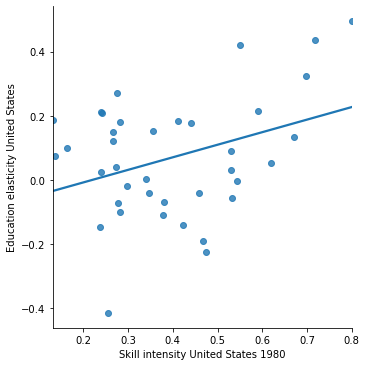

In [355]:
ax = sns.lmplot(x='ratio80', y='elastedu', ci = None, data=shares_joint_ratio)
ax.set(xlabel='Skill intensity United States 1980', ylabel='Education elasticity United States')

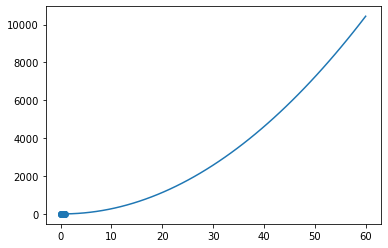

In [275]:
#polynomial fit with degree = 2
model = np.poly1d(np.polyfit( shares_joint_ratio['ratio80'],  shares_joint_ratio['elastedu'], 2))

#add fitted polynomial line to scatterplot
polyline = np.linspace(1, 60, 50)
plt.scatter(shares_joint_ratio['ratio80'],  shares_joint_ratio['elastedu'])
plt.plot(polyline, model(polyline))
plt.show()

In [276]:
'''
ax = sns.scatterplot(x='ratio80', y='elastedu', data=shares_joint_ratio)
ax.set(xlabel='Skill intensity United States 1980', ylabel='Education elasticity United States')
'''

"\nax = sns.scatterplot(x='ratio80', y='elastedu', data=shares_joint_ratio)\nax.set(xlabel='Skill intensity United States 1980', ylabel='Education elasticity United States')\n"

In [277]:
shares_joint_ratio['sic'] = np.nan

shares_joint_ratio.loc[shares_joint_ratio['ind'] == 1, 'sic'] = 17 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 2, 'sic'] = 121 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 3, 'sic'] = 19
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 4, 'sic'] = 18 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 5, 'sic'] = 121 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 6, 'sic'] = 22
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 7, 'sic'] = 124 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 8, 'sic'] = 45
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 9, 'sic'] = 124 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 10, 'sic'] = 14 

shares_joint_ratio.loc[shares_joint_ratio['ind'] == 11, 'sic'] = 67 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 12, 'sic'] = 11 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 13, 'sic'] = 12
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 14, 'sic'] = 13 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 15, 'sic'] = 6 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 16, 'sic'] = 86
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 17, 'sic'] = 124 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 18, 'sic'] = 32
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 19, 'sic'] = 68 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 20, 'sic'] = 116 

shares_joint_ratio.loc[shares_joint_ratio['ind'] == 21, 'sic'] = 115 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 22, 'sic'] = 91 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 23, 'sic'] = 104
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 24, 'sic'] = 92
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 25, 'sic'] = 64
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 26, 'sic'] = 122
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 27, 'sic'] = 6 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 28, 'sic'] = 95
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 29, 'sic'] = 76 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 30, 'sic'] = 73 

shares_joint_ratio.loc[shares_joint_ratio['ind'] == 31, 'sic'] = 72
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 32, 'sic'] = 81 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 33, 'sic'] = 118
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 34, 'sic'] = 119
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 35, 'sic'] = 113 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 36, 'sic'] = 113
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 37, 'sic'] = 113 
shares_joint_ratio.loc[shares_joint_ratio['ind'] == 38, 'sic'] = 126


In [283]:
skilloecdUS = pd.read_stata('skilloecdUS')
shares_joint_ratio_new = pd.merge(shares_joint_ratio, skilloecdUS, on='sic')

,ind,elastedu,elastincome,ratio80,educbeta,incomebeta,sigmaedu,sigmaincome,meansh,sgdum,ratio802,hat,hat1,sic,id,skiloecd
0,1.0,-0.147344,0.740111,0.236263,-0.051537,-0.047423,0.003674,0.005294,0.182473,0.001285,0.055820,-0.033839,-0.025373,17.0,1,0.330670
1,2.0,0.121152,1.091576,0.265507,0.012999,0.005126,0.006566,0.010854,0.055977,0.000705,0.070494,-0.024423,-0.039433,121.0,1,0.295848
2,5.0,0.149348,1.139961,0.265000,0.001827,0.000893,0.017431,0.023225,0.006383,0.000213,0.070225,-0.024586,-0.039228,121.0,1,0.295848
3,3.0,-0.415191,0.716143,0.254717,-0.011690,-0.004169,0.015119,0.022542,0.014688,0.000426,0.064881,-0.027897,-0.034771,19.0,1,0.437436
4,4.0,0.001460,0.949225,0.338983,0.000020,-0.000360,0.015566,0.024871,0.007091,0.000212,0.114910,-0.000763,-0.054828,18.0,1,0.333927
5,6.0,0.073944,1.115562,0.135813,0.006713,0.005473,0.006714,0.010483,0.047360,0.000609,0.018445,-0.066185,0.057321,22.0,1,0.245101
6,7.0,0.023766,0.906697,0.239500,0.000297,-0.000607,0.011293,0.017796,0.006510,0.000141,0.057360,-0.032797,-0.027152,124.0,1,0.327385
7,9.0,0.040888,0.973281,0.273007,0.001019,-0.000347,0.008066,0.018301,0.013001,0.000201,0.074533,-0.022008,-0.042311,124.0,1,0.327385
8,17.0,0.185361,1.237561,0.130806,0.007807,0.005220,0.011819,0.013505,0.021974,0.000498,0.017110,-0.067797,0.062837,124.0,1,0.327385
9,8.0,0.208344,1.658046,0.241667,0.001802,0.002969,0.027911,0.035263,0.004512,0.000241,0.058403,-0.032099,-0.028312,45.0,1,0.386692


In [284]:
#correlation between skill intensity and skill adjusted
df2 = pd.DataFrame(shares_joint_ratio_new,columns=['ratio80', 'skiloecd'])
corrMatrix2 = df2.corr()
corrMatrix2

,ratio80,skiloecd
ratio80,1.000000,0.886642
skiloecd,0.886642,1.000000


In [289]:
### INFO FOR TABLE 2
#1st regression function and results
Y = shares_joint_ratio["elastedu"]
X = shares_joint_ratio["ratio80"]
w = shares_joint_ratio["meansh"]
X = sm.add_constant(X)
model = sm.WLS(Y,X,w)
results3 = model.fit()
print(results3.summary()) 

                            WLS Regression Results                            
Dep. Variable:               elastedu   R-squared:                       0.091
Model:                            WLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.587
Date:                Tue, 16 Mar 2021   Prob (F-statistic):             0.0663
Time:                        15:31:52   Log-Likelihood:                 8.1695
No. Observations:                  38   AIC:                            -12.34
Df Residuals:                      36   BIC:                            -9.064
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1099      0.063     -1.745      0.0

In [291]:
#2nd regression function and results
X = shares_joint_ratio[["ratio80","ratio802"]] 
y = shares_joint_ratio["elastedu"]
w = shares_joint_ratio["meansh"]
## fit a WLS model 
X = sm.add_constant(X)
est = sm.WLS(y, X, w).fit()
print(est.summary())

                            WLS Regression Results                            
Dep. Variable:               elastedu   R-squared:                       0.285
Model:                            WLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     6.974
Date:                Tue, 16 Mar 2021   Prob (F-statistic):            0.00282
Time:                        15:35:41   Log-Likelihood:                 12.737
No. Observations:                  38   AIC:                            -19.47
Df Residuals:                      35   BIC:                            -14.56
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2539      0.131      1.940      0.0

In [292]:
#3rd regression function and results
Y = shares_joint_ratio["elastincome"]
X = shares_joint_ratio["ratio80"]
w = shares_joint_ratio["meansh"]
X = sm.add_constant(X)
model = sm.WLS(Y,X,w)
results3 = model.fit()
print(results3.summary()) 

                            WLS Regression Results                            
Dep. Variable:            elastincome   R-squared:                       0.119
Model:                            WLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.853
Date:                Tue, 16 Mar 2021   Prob (F-statistic):             0.0341
Time:                        15:37:18   Log-Likelihood:                -8.5209
No. Observations:                  38   AIC:                             21.04
Df Residuals:                      36   BIC:                             24.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8016      0.098      8.201      0.0

In [293]:
#4th regression function and results
X = shares_joint_ratio[["ratio80","ratio802"]] 
y = shares_joint_ratio["elastincome"]
w = shares_joint_ratio["meansh"]
## fit a WLS model 
X = sm.add_constant(X)
est = sm.WLS(y, X, w).fit()
print(est.summary())

                            WLS Regression Results                            
Dep. Variable:            elastincome   R-squared:                       0.265
Model:                            WLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     6.303
Date:                Tue, 16 Mar 2021   Prob (F-statistic):            0.00459
Time:                        15:38:37   Log-Likelihood:                -5.0797
No. Observations:                  38   AIC:                             16.16
Df Residuals:                      35   BIC:                             21.07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2985      0.209      6.210      0.0

In [344]:
ratio80 = [0.322,-1.806,0.581,-2.325,' ',' ',' ',' ']
ratio802 = [' ',2.641,' ',3.607,' ',' ',' ',' ']
skiloecd = [' ',' ',' ',' ',0.468,-4.532,0.824,-5.900]
skiloecd2 = [' ',' ',' ',' ',' ',5.865,' ',7.887]
Constant1 = [-0.110,0.254,0.802,1.299,' ',' ',' ',' ']
R_squared1 = [0.091,0.285,0.119,0.265,' ',' ',' ',' ']
Constant2 = [' ',' ',' ',' ',-0.178, 0.826, 0.688, 2.037]
R_squared2 = [' ',' ',' ',' ', 0.078, 0.288, 0.097, 0.250]

In [345]:
def table_1(ratio80,ratio802,Constant1,R_squared1,skiloecd,skiloecd2,Constant2,R_squared2):
    
    table = pd.DataFrame()

    table['β1'] = ratio80
    table['β2'] = ratio802
    table['β3'] = Constant1
    table['β4'] = R_squared1
    table['C1'] = skiloecd
    table['C2'] = skiloecd2
    table['C3'] = Constant2
    table['C4'] = R_squared2
    table['Variable'] = ["Skill intensity 1980","Skill intensity 1980 squared","Constant1", "R^21","AD Skill intensity 1980","AD Skill intensity 1980 squared","Constant2", "R^22"]
    table = table.set_index('Variable')
    
    return(table) 

In [346]:
##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

TABLE1 = table_1(ratio80,ratio802,Constant1,R_squared1,skiloecd,skiloecd2,Constant2,R_squared2)
TABLE1

,β1,β2,β3,β4,C1,C2,C3,C4
Variable,,,,,,,,
Skill intensity 1980,0.322,,-0.11,0.091,,,,
Skill intensity 1980 squared,-1.806,2.641,0.254,0.285,,,,
Constant1,0.581,,0.802,0.119,,,,
R^21,-2.325,3.607,1.299,0.265,,,,
AD Skill intensity 1980,,,,,0.468,,-0.178,0.078
AD Skill intensity 1980 squared,,,,,-4.532,5.865,0.826,0.288
Constant2,,,,,0.824,,0.688,0.097
R^22,,,,,-5.9,7.887,2.037,0.25


In [314]:
shares_joint_ratio_new['skiloecd2'] = shares_joint_ratio_new['skiloecd'] **2

#1st regression function and results
Y = shares_joint_ratio_new["elastedu"]
X = shares_joint_ratio_new["skiloecd"]
w = shares_joint_ratio_new["meansh"]
X = sm.add_constant(X)
model = sm.WLS(Y,X,w)
results3 = model.fit()
print(results3.summary()) 

#2nd regression function and results
X = shares_joint_ratio_new[["skiloecd","skiloecd2"]] 
y = shares_joint_ratio_new["elastedu"]
w = shares_joint_ratio_new["meansh"]
## fit a WLS model 
X = sm.add_constant(X)
est = sm.WLS(y, X, w).fit()
print(est.summary())

#3rd regression function and results
Y = shares_joint_ratio_new["elastincome"]
X = shares_joint_ratio_new["skiloecd"]
w = shares_joint_ratio_new["meansh"]
X = sm.add_constant(X)
model = sm.WLS(Y,X,w)
results3 = model.fit()
print(results3.summary()) 

#4th regression function and results
X = shares_joint_ratio_new[["skiloecd","skiloecd2"]] 
y = shares_joint_ratio_new["elastincome"]
w = shares_joint_ratio_new["meansh"]
## fit a WLS model 
X = sm.add_constant(X)
est = sm.WLS(y, X, w).fit()
print(est.summary())

                            WLS Regression Results                            
Dep. Variable:               elastedu   R-squared:                       0.078
Model:                            WLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     3.039
Date:                Tue, 16 Mar 2021   Prob (F-statistic):             0.0898
Time:                        18:32:09   Log-Likelihood:                 7.9048
No. Observations:                  38   AIC:                            -11.81
Df Residuals:                      36   BIC:                            -8.534
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1776      0.105     -1.694      0.0